### Imports

In [1]:
import pandas as pd
import numpy as np
import torch

### Load sequence data from cryptic seq experiment

In [3]:
# Load data from cryptic seq experiment
sites_xl = pd.ExcelFile('./data/TB000208a.outputs.xlsx')
sites_xl.sheet_names
training_sheets = ['GT-Rep1-N7_S1','GT-Rep2-N7_S2','GT-Rep3-N7_S3']
sheets = []
for name in training_sheets:
    sheets.append(sites_xl.parse(name))
sites = pd.concat(sheets).reset_index()

# Only take canonical dinucleotide insertions
sites = sites[sites['genome_dinucleotide'] == sites['donor'].str.slice(5,7)]

# Average count at identical sites
sites = sites.groupby(['seq'], as_index=False).sum(numeric_only=False)
sites['count'] = np.log(sites['count'])

In [4]:
# Keys for sites dataframe
SEQ = 'seq'
COUNT = 'count'

In [5]:
# Split into left and right
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
reverse_complement = lambda x: "".join(complement.get(base, base) for base in reversed(x))

left = sites[SEQ].str.slice(0,22)
left_rc = left.apply(reverse_complement)
right = sites[SEQ].str.slice(24,)
right_rc = right.apply(reverse_complement)

sites['left'] = left
sites['right'] = right_rc

combined_sites = pd.concat([pd.DataFrame({"seq": sites[key], "count": sites['count']}) for key in ['left', 'right']]).reset_index()

# Use symmetric sites as data input
sites = combined_sites

In [6]:
import genome_utils
import genomepy
from sklearn.preprocessing import StandardScaler

genomic_reference_file = '../data/references/hg38.fa'

# Extract cryptic sites
hits = sites[SEQ]
hit_count = len(hits)
hits_labels = sites[COUNT]

# Length of a cryptic site
seq_length = len(hits[0])

# Generate random decoy sequences
genome = genomepy.genome.Genome(genomic_reference_file)
samples = genome.get_random_sequences(n=hit_count, length=seq_length-1, max_n=0)
decoys = pd.Series(list(map(lambda row: genome.get_seq(*row).seq.upper(), samples)))
decoys_labels = np.zeros(len(decoys))

# Concatenate hits and decoys
#sequences = np.hstack([hits, decoys])
#labels = np.hstack([hits_labels, decoys_labels])

# Positive data only
sequences = hits.values
labels = hits_labels.values

# Set dinucleotide to NN in both hits and decoys
#dn_start = int(seq_length/2)
#hits = hits.apply(lambda seq: seq[:dn_start-1] + 'NN' + seq[dn_start+1:])

# Scale values
'''
scaler = StandardScaler()
scaler.fit(labels.reshape(-1, 1))
labels = scaler.transform(labels.reshape(-1, 1)).squeeze()
'''

'\nscaler = StandardScaler()\nscaler.fit(labels.reshape(-1, 1))\nlabels = scaler.transform(labels.reshape(-1, 1)).squeeze()\n'

In [7]:
from models import mlp
from datasets import one_hot

vocab_size = 5
hidden_size = 2048
n_hidden = 2
train_test_split = 0.8

dataset = one_hot.Dataset(sequences, labels, vocab_size=vocab_size)

# Test and train data split
train_size = int(train_test_split*len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Build model
model = mlp.Model(input_size=seq_length*vocab_size, hidden_size=hidden_size, output_size=1, n_hidden=n_hidden, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [8]:
from sklearn.metrics import mean_squared_error, accuracy_score

epochs = 10
loss_fn = torch.nn.MSELoss()

# training loop
for epoch in range(epochs):
    train_loss = 0.0
    train_preds, train_targets = [], []

    # Training Phase
    for i, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data).flatten()

        # Convert output probabilities to predicted class
        preds = output.float()
        train_preds.extend(preds.tolist())
        train_targets.extend(target.tolist())

        loss = loss_fn(output, target.float())
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_error = mean_squared_error(train_targets, train_preds)

    print(f"Epoch {epoch}/{epochs}")
    print(f"-------------")
    print(f"Train loss: {train_loss/len(train_dataloader)}")

    val_loss = 0.0
    val_preds, val_targets = [], []

    # Validation Phase
    with torch.no_grad():
        for i, (data, target) in enumerate(val_dataloader):
            output = model(data).flatten()

            # Convert output probabilities to predicted class
            preds = output.float()
            val_preds.extend(preds.tolist())
            val_targets.extend(target.tolist())

            loss = loss_fn(output, target.float())
            val_loss += loss.item()

        val_error = mean_squared_error(val_targets, val_preds)

    print(f"Val loss: {val_loss/len(val_dataloader)}")
    print(f"-------------\n")

Epoch 0/10
-------------
Train loss: 2.114472519294973
Val loss: 2.029851622864514
-------------

Epoch 1/10
-------------
Train loss: 2.0620008422828993
Val loss: 2.0296201969776115
-------------

Epoch 2/10
-------------
Train loss: 2.0222034954052317
Val loss: 2.045419261369187
-------------

Epoch 3/10
-------------
Train loss: 1.9795797891607216
Val loss: 2.1162545329608187
-------------

Epoch 4/10
-------------
Train loss: 1.9048140988068998
Val loss: 2.1845018290418015
-------------

Epoch 5/10
-------------
Train loss: 1.8083047145022846
Val loss: 2.252738809681514
-------------

Epoch 6/10
-------------
Train loss: 1.6782986700294722
Val loss: 2.428946274267116
-------------

Epoch 7/10
-------------
Train loss: 1.5473287026927791
Val loss: 2.466098304725509
-------------

Epoch 8/10
-------------
Train loss: 1.429731029863324
Val loss: 2.6269418847872696
-------------

Epoch 9/10
-------------
Train loss: 1.3351295387216686
Val loss: 2.61760708383871
-------------



### Analysis

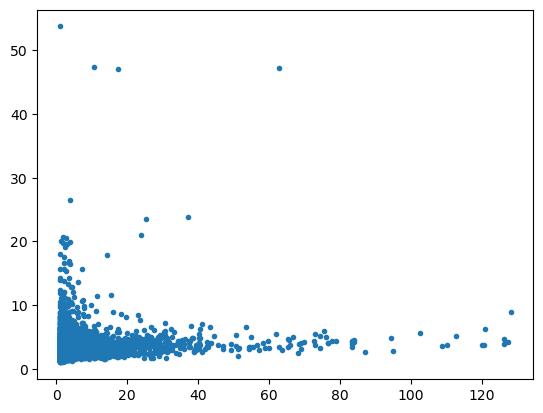

In [53]:
from matplotlib import pyplot as plt

# Iterate over the DataLoader and make predictions
val_inputs = []
val_targets = []
val_preds = []
with torch.no_grad():
    for i, (data, target) in enumerate(val_dataloader):
        output = model(data).flatten()

        # Convert output probabilities to predicted class
        preds = output.float()

        # Save prediction data
        val_inputs.extend(data.tolist())
        val_preds.extend(preds.tolist())
        val_targets.extend(target.tolist())

# Translate inputs
trans_dict = {0:'A',1:'T',2:'C',3:'G',4:'N'}
translate_func = lambda x: ''.join([trans_dict[y] for y in x])

inputs = np.argmax(val_inputs, axis=2)
inputs = [translate_func(x) for x in inputs]

predictions = pd.DataFrame({"seq":inputs, "targets":val_targets, "outputs": val_preds})
plt.plot(val_targets, val_preds, '.')

In [36]:
for seq in predictions[predictions['targets'] > 4]['seq']:
    print(seq)

ACTTAGAGTCCCAACTACAGAG
TGGTTACAACCTAACTACTGAG
TTTGTCAACTTCAGCAACTGGG
AATAATTTTGTAAACTGTAGAG
TAGTAGTAGTAGTGCCACAGTG
TGACCTGGTTTATTCAACAGCA
TATCTGGATAGAAACCACAGCA
TGTTTGGGCTTTAACATCAGAC
TCACAGTGTTTAGAACATTGTA
AACTGAAGCTTCTACAACTGGA
CTCTTGAGTCTTTACACTTGAG
TTTCAGGATCTTAATCTCTGAG
TTTGTAGAGTTAGTCCTTAGAG
AGGATAGCCTGTCACCTTAGAG
TGTACCTGCTCCTCCAACAGCA
TAATTTTTTGTTGGTGGTAGCC
AAGTCAAGCTTCTCCACCTGGT
TCATTGAGGCTCTCCTGCTGAG
TTGTATGCACTGAGCTACTGTA
GGGTGGTTTGTGTCCATCAGAA
GTGGGTTGTGTATACATCTGCT
TTAACTAGTTGCTCCAATTGCA
GATGGTGATCCACGCAACAGAC
TGTGTGTTTCTTTACCATTGAA
GCTCTGAGTCTATACAACCGAG
CAGGAGGTTTTCAGCACCAGTG
ACAAAGGCTTCTGACATCAGAA
AGATGGACTCCTGACAAGGGAA
AGAATGGGTTTGGACCAAAGGA
AGAAGCTGCTTCTCCCATGGAG
ATAAATTACTTCAACACCAGGA
TACATGGTGGCTGATAACTGAG
CACCACCCATATGGCAACGGAG
CAGTCAATTTCCAACTGCAGAC
ATTTTATATATGCACAACTGTG
CAGTGGTTTGACCACAACAGTG
CGTCTCAGCTTCTACTGCGGAA
AGTGTGGATTTCCACAGGTGAG
TGTATAGGTTTAGACAATAGAG
AGTAACTGCTTGGATTACTGCC
CAACTTGATCTATAGAGTTGAG
GAGGATGAACCTAGCAGCAGCC
GCCTCCTGCTTGCTCAGCTGAG
TGGTTACAACC

In [88]:
trans_dict = {0:'A',1:'T',2:'C',3:'G',4:'N'}
translate_func = lambda x: ''.join([trans_dict[y] for y in x])

inputs = np.argmax(data, axis=2).numpy()
inputs = [translate_func(x) for x in inputs]

preds = pd.DataFrame({'inputs':inputs, })

['TGCTAAAATTGTTGCTGCTGTTNNTGCTATTGTTGGTTTTGTTGTT',
 'CACTTGAATCCAGGAGGCGGAGNNTGCAGTGAGCCGAGATCACGTC',
 'TGCTTGAACCTGGGAGACAGAGNNTGCAGTGAGCCGAGATTGCACC',
 'ATGCATGCCTCCTGCAGCTGCANNTTCTGCTGTGGCAGCTGTGTCT',
 'CCATGTTTTTAATGCAGCTCAGNNGTCTGTAGTCTGAGGCAGTGAG',
 'CTTTGATGTTTTTACTTATGCANNTTCAATTATCTAAGTTCCCTTC']